# **Workshop VII** <br/> *Bayesian inference and decision trees*

In this exercise, please fill in the blanks that indicated by ...

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy.stats import beta, norm, bernoulli

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from decimal import Decimal

import ID3  # decision tree module

---

## **1.** Bayesian Basics

This first exercise is meant as an introduction to the Bayesian framework. In particular, we will simulate a dataset of disease contamination. By simulating the dataset, we know the "true" parameter values and we can thus examine how accurate our inferences are. To get started, lets set up the simulation parameters.

In [2]:
# simulate a population of 100,000 people:
population = 100_000
prevalence = 0.01   # disease prevalence
sensitivity = 0.95  # true positive rate
specificity = 0.90  # true negative rate

# infectious status (1 = infected, 0 = not infected):
population_status = np.random.choice([1, 0], size=population, p=[prevalence, 1-prevalence])

# assign some fictitious test results to the population, based on our sensitivity and specificity:
test_results = np.zeros(population)
for i in range(population):
    if population_status[i] == 1:
        test_results[i] = np.random.choice([1, 0], p=[sensitivity, 1-sensitivity])
    else:
        test_results[i] = np.random.choice([1, 0], p=[1-specificity, specificity])


In [3]:
# create a dataframe to store the population data:
df = pd.DataFrame({'status': population_status, 'test_result': test_results})

#### Now, assuming that we have access to both the test results and the true results (the "status"), try to extract the Baysian probabilities from our simulated data, to find out posterior probability of being infected, given a positive test result. 

In [4]:
# calculate the Bayesian probabilities:
prior_probability = df['status'].mean()
likelihood = df[df['status'] == 1]['test_result'].mean()
probability_testing_positive = df['test_result'].mean()

print('Prior probability of infection:', prior_probability)
print('Likelihood of testing positive given infection:', likelihood)
print('Probability of testing positive:', probability_testing_positive)

Prior probability of infection: 0.00965
Likelihood of testing positive given infection: 0.960621761658031
Probability of testing positive: 0.10838


#### Complete the function to calculate posterior, and them use it to get the posterior.

In [5]:
# Bayesian inference of Pr(status=1 | test=1)
def bayes_theorem(prior, likelihood, evidence):
    return (prior*likelihood)/evidence

pr_infected_given_positive = bayes_theorem(prior_probability, likelihood, probability_testing_positive)

# print posterior. which is (Pr(test=1 | status=1) * Pr(status=1)) / Pr(test=1)
print('Pr(status=1 | test=1) = ', pr_infected_given_positive) 

Pr(status=1 | test=1) =  0.08553238604908654


#### Interpret your finding.

The probability of being infected and being tested positive is 8.75%

### If sensitivity is increased to 0.999, the specificity remains as original, what is the value of Pr(status=1 | test=1)?

#### If specificity is increased to 0.999, the sensitivity remains as original, what is the value of Pr(status=1 | test=1)?

#### Interprete your finding.

If sensitivity is increased to 0.999, Pr(status=1 | test=1) increases to 9.23%

If specifity = 0.99, Pr(status=1 | test=1) increases to 9.11%

That would mean that probability of being infected and being tested positive is higher if sensivity or specifity is higher 

---

## **2.** Dealing with Uncertainty

Of course, we are never able to take a peak into the true population parameters in real life. There will always be uncertainty. So far you have tried to quantify this uncertainty using frequentist techniques (i.e. maximum likelihood estimations, etc). Today you will quantify your uncertainty differently, using Bayesian statistics.

In the following, you will try to use Bayesian inference to go from data to results.

Now suppose we want to estimate the average weight of fish in a fishery farm. The real average weight of the fish is 2 kg. but we do not know this value beforehand. After a number of catches, we get data on the weight of a batch of fish. We know that the weights of the detected fish obeys a normal distribution around the mean value. How can we obtain the actual average weight of the fish from this data?

Let's start by adding some small data that obeys normal distribution. The mean is set to be 2 and the standard deviation is 1.

The Data generated from the following code:

#np.random.seed = 39

#sample_data = np.random.normal(2, 1, 30)

In [6]:
sample_data = np.array([ 1.64350291,  0.87752135,  3.05569158,  1.48274427,  1.4059861 ,
        3.93554187,  0.53890017,  2.12058382,  0.54360397,  2.25308647,
        2.71833633,  2.11059019,  0.90982909,  3.10162428,  2.99375448,
        1.9048221 ,  2.25047556,  2.60237373,  1.59678977,  2.00217239,
        1.3469326 ,  1.05712171,  0.32794892,  3.36094034, -0.42828078,
        1.27685994,  2.84693071,  3.21779923,  0.15080283,  2.29198599])

Now, because we cannot obtain the true value anymore, we set up a *prior distribution* to represent our uncertainty. 

Set up 4 priors to compare their effect on the posterior distribution later. Use the population value obtained in the previous part (i.e. approximately 0.0.1).

In [7]:
x_range = np.linspace(1,3,100)

# Prior 1: uncertain
prior1 = beta.pdf(x_range/3.0, 1, 1)/3.0

# Prior 2: somewhat uncertain
prior2 = beta.pdf(x_range/3.0, 1, 3)/3.0

# Prior 3: somewhat certain
prior3 = beta.pdf(x_range/3.0, 5, 3)/3.0

# Prior 4: certain
prior4 = beta.pdf(x_range/3.0, 30, 15)/3.0

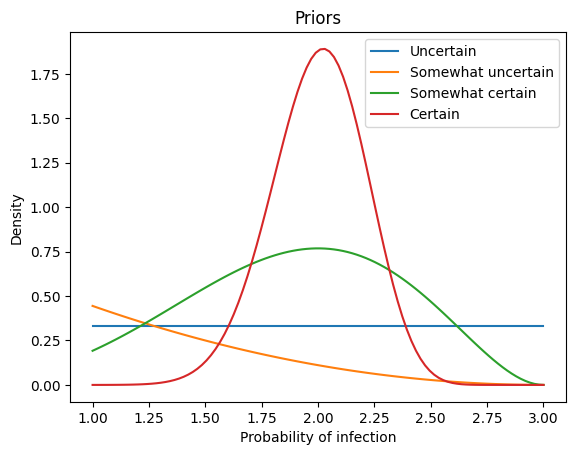

In [8]:
for prior, title in zip([prior1, prior2, prior3, prior4], ['Uncertain', 'Somewhat uncertain', 'Somewhat certain', 'Certain']):
    plt.plot(x_range, prior, label=title)

plt.xlabel('Probability of infection')
plt.ylabel('Density')
plt.title('Priors')
plt.legend()

#### Equiped with the prior distributions, we now form the likelihood.

In [9]:
# multiply log elements together
def multiply_elements(array):
    return np.log(array).sum()

# computing exponential function and normalization for large value
def largeExpNormalize(x_range,loglikelihoodlist):
    declikelihood = [Decimal(k).exp() for k in loglikelihoodlist]
    
    surface = Decimal(0)
    for i in range(1,len(x_range)):
        surface += Decimal(x_range[i]-x_range[i-1])*declikelihood[i]        
    
    mlh = [float(k/surface) for k in declikelihood]
    return mlh

# Gaussian pdf
def loglikelihood_function_normal(data,miu,sigma):
    return multiply_elements(norm.pdf(data, miu, sigma))

loglikelihoodlist = []
sigma = np.std(sample_data,ddof=1)
for miu in x_range:
    p = loglikelihood_function_normal(sample_data,miu,sigma)
    loglikelihoodlist.append(p)

mlh = largeExpNormalize(x_range,loglikelihoodlist)

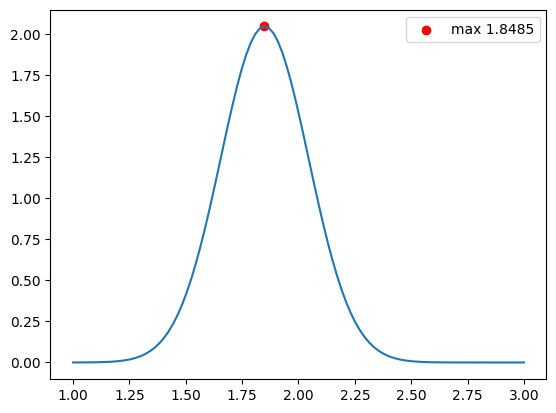

In [10]:
plt.plot(x_range, mlh)
plt.scatter(x_range[np.argmax(mlh)], mlh[np.argmax(mlh)], color='red',label="max %.4f"%(x_range[np.argmax(mlh)]))
plt.legend()

#### Compute the posterior with prior 1-4 and plot them. A function to compute the area under the curve is available.

In [11]:
def getSurface(x,y):
    surface = 0
    for i in range(1,len(x)):
        surface += (x[i]-x[i-1])*y[i]        
    return surface 

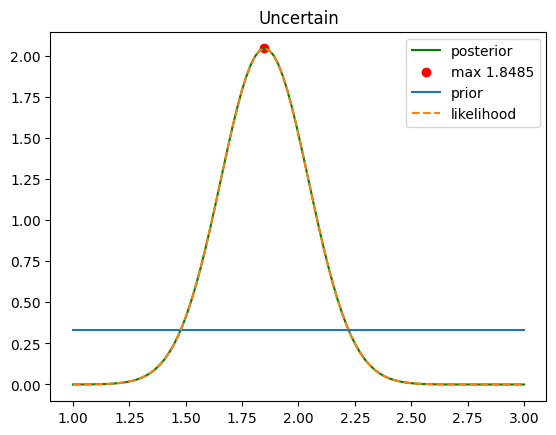

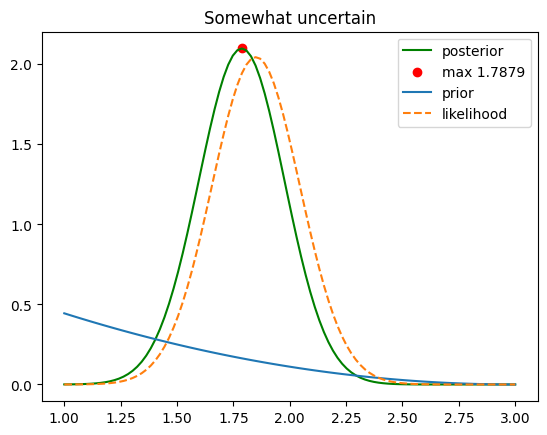

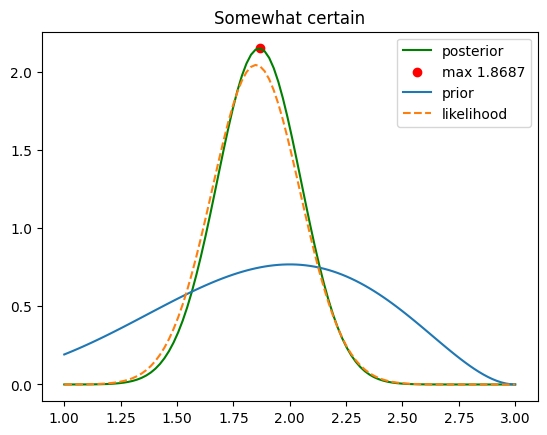

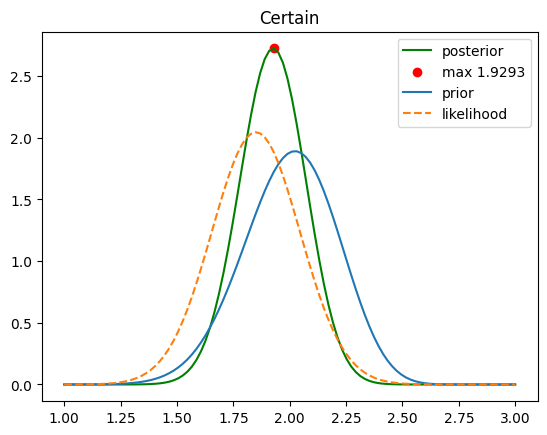

In [12]:
for prior, title in zip([prior1, prior2, prior3, prior4], ['Uncertain', 'Somewhat uncertain', 'Somewhat certain', 'Certain']):
    
    posterior = (mlh * prior)
    posterior /= getSurface(x_range, posterior)  # normalize

    plt.plot(x_range, posterior, 'g', label="posterior")
    plt.scatter(x_range[np.argmax(posterior)], posterior[np.argmax(posterior)], color='red',label="max %.4f"%(x_range[np.argmax(posterior)]))
    
    plt.plot(x_range, prior, label="prior")
    plt.plot(x_range, mlh, linestyle='--', label="likelihood")

    plt.legend()
    plt.title(title)
    plt.show()

Interpret the above plots.

Uncertain plot -> prior follow the curve of the posterior

somewhat uncertain plot -> Prior a bit better shows a change

somewhat certain -> Prior shows slight spike

certain -> Prior and posterior have very similar shape


---

## 3. Decision Trees: ID3

Kaggle: https://www.kaggle.com/datasets/pablomgomez21/drugs-a-b-c-x-y-for-decision-trees

In [14]:
# import data
df = pd.read_csv('files//drug200.csv')
df.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,drugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,drugY


In [15]:
# drop missing values
df = df.dropna()

In [16]:
# Binning 'Na_to_K' (sodium - potassium) into categories
bins_NA_K = [0, 10, 20, 30, 40]
labels_NA_K = ['below 10', '11-20', '21-30', '31-40']
df['Na_to_K'] = pd.cut(df['Na_to_K'], bins=bins_NA_K, labels=labels_NA_K, include_lowest=True)

# Binning 'Na_to_K' (sodium - potassium) into categories
bins_Age = [0, 20, 40, 60, 80]
labels_Age = ['below 20', '21-40', '41-60', '61-80']
df['Age'] = pd.cut(df['Age'], bins=bins_Age, labels=labels_Age, include_lowest=True)

df = df.astype(str)

df['Cholesterol'] = df['Cholesterol'] + '-Chol'
df['BP'] = df['BP'] + '-BP'

# show
print([type(df.iloc[0,i]) for i in range(len(df.columns))])
df.head()

[<class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>, <class 'str'>]


,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,21-40,F,HIGH-BP,HIGH-Chol,21-30,drugY
1,41-60,M,LOW-BP,HIGH-Chol,11-20,drugC
2,41-60,M,LOW-BP,HIGH-Chol,11-20,drugC
3,21-40,F,NORMAL-BP,HIGH-Chol,below 10,drugX
4,61-80,F,LOW-BP,HIGH-Chol,11-20,drugY


#### Split the dataset into training and test sets.

In [17]:
# Split the dataset into training and test sets
df = df.rename(columns={'Drug':'class'})
data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)

#### Now, using the provided ID3 algorithm, construct a decision tree using the training set.

In [18]:
# Construct the decision tree from the provided ID3 algorithm
features = list(data_train.columns[:-1])
decision_tree = ID3.ID3(data_train, data_train, features, 'class')

In [19]:
# Print the tree to get an idea of its structure
ID3.print_tree(decision_tree)

BP
|--- HIGH-BP
|   |--- Na_to_K
|   |   |--- 11-20
|   |   |   |--- Age
|   |   |   |   |--- 21-40
|   |   |   |   |   |--- Sex
|   |   |   |   |   |   |--- F
|   |   |   |   |   |   |   |--- Cholesterol
|   |   |   |   |   |   |   |   |--- HIGH-Chol
|   |   |   |   |   |   |   |   |   |--- drugA
|   |   |   |   |   |   |   |   |--- NORMAL-Chol
|   |   |   |   |   |   |   |   |   |--- drugY
|   |   |   |   |   |   |--- M
|   |   |   |   |   |   |   |--- Cholesterol
|   |   |   |   |   |   |   |   |--- HIGH-Chol
|   |   |   |   |   |   |   |   |   |--- drugY
|   |   |   |   |   |   |   |   |--- NORMAL-Chol
|   |   |   |   |   |   |   |   |   |--- drugA
|   |   |   |   |--- 41-60
|   |   |   |   |   |--- Sex
|   |   |   |   |   |   |--- F
|   |   |   |   |   |   |   |--- Cholesterol
|   |   |   |   |   |   |   |   |--- HIGH-Chol
|   |   |   |   |   |   |   |   |   |--- drugB
|   |   |   |   |   |   |   |   |--- NORMAL-Chol
|   |   |   |   |   |   |   |   |   |--- drugB
|   |   |   |   |

#### Implement a code to use the constructed decision tree to make predictions on the test set.

In [20]:
# The 'class' column should not be included in the features of the test set
test_features = data_test.drop('class', axis=1)
actual_values = data_test['class'].tolist()

# Use the new prediction function to get predictions for the test set
# default value is used when no result is obtained
predictions = ID3.predictDataset(test_features, decision_tree, default="DrugA")

# Compare the predictions with the actual values
comparison = pd.DataFrame({'Actual': actual_values, 'Predicted': predictions})

print(comparison)

   Actual Predicted
0   drugX     drugX
1   drugY     drugY
2   drugX     drugX
3   drugC     drugC
4   drugY     drugY
5   drugY     drugA
6   drugY     drugY
7   drugX     drugX
8   drugA     drugA
9   drugX     drugX
10  drugA     drugY
11  drugX     DrugA
12  drugY     DrugA
13  drugA     drugA
14  drugB     drugB
15  drugY     drugX
16  drugB     drugY
17  drugX     drugX
18  drugC     drugC
19  drugY     drugY
20  drugB     drugB
21  drugX     drugX
22  drugX     drugX
23  drugY     drugY
24  drugY     drugY
25  drugY     drugY
26  drugC     drugC
27  drugX     DrugA
28  drugY     drugY
29  drugX     drugX
30  drugY     drugX
31  drugC     drugC
32  drugC     drugC
33  drugY     drugY
34  drugA     drugA
35  drugY     drugY
36  drugX     drugX
37  drugA     drugA
38  drugY     drugY
39  drugA     drugA


Accuracy: 0.8000


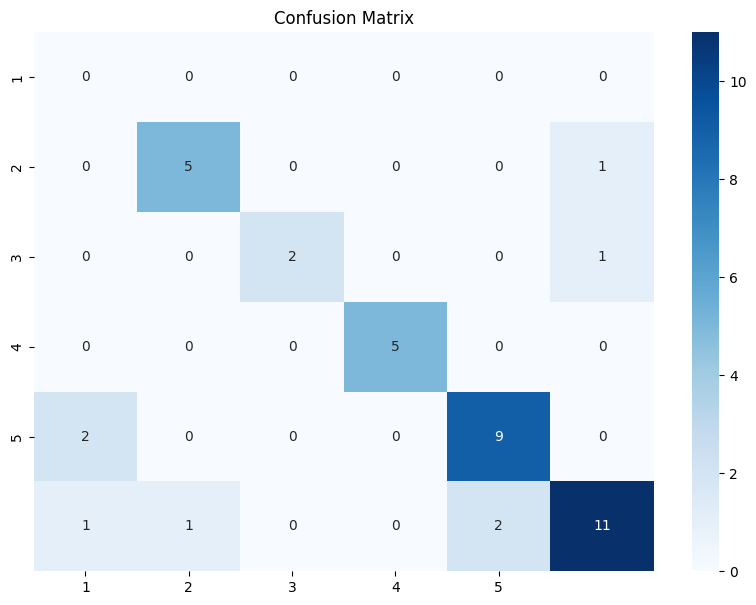

In [21]:
# Visualize the accuracy
accuracy = accuracy_score(actual_values, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(actual_values, predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=['1', '2', '3', '4', '5'], yticklabels=['1', '2', '3', '4', '5'])
plt.title('Confusion Matrix')
plt.show()

Finally, interpret your decision tree:

In [22]:
ID3.print_tree(decision_tree)

BP
|--- HIGH-BP
|   |--- Na_to_K
|   |   |--- 11-20
|   |   |   |--- Age
|   |   |   |   |--- 21-40
|   |   |   |   |   |--- Sex
|   |   |   |   |   |   |--- F
|   |   |   |   |   |   |   |--- Cholesterol
|   |   |   |   |   |   |   |   |--- HIGH-Chol
|   |   |   |   |   |   |   |   |   |--- drugA
|   |   |   |   |   |   |   |   |--- NORMAL-Chol
|   |   |   |   |   |   |   |   |   |--- drugY
|   |   |   |   |   |   |--- M
|   |   |   |   |   |   |   |--- Cholesterol
|   |   |   |   |   |   |   |   |--- HIGH-Chol
|   |   |   |   |   |   |   |   |   |--- drugY
|   |   |   |   |   |   |   |   |--- NORMAL-Chol
|   |   |   |   |   |   |   |   |   |--- drugA
|   |   |   |   |--- 41-60
|   |   |   |   |   |--- Sex
|   |   |   |   |   |   |--- F
|   |   |   |   |   |   |   |--- Cholesterol
|   |   |   |   |   |   |   |   |--- HIGH-Chol
|   |   |   |   |   |   |   |   |   |--- drugB
|   |   |   |   |   |   |   |   |--- NORMAL-Chol
|   |   |   |   |   |   |   |   |   |--- drugB
|   |   |   |   |

The first main variable that splits the data is BP, then Na_to_K, Age, sex, and cholesterol

---

## **4.** Decision Trees: CART

This time we try to use the python build-in function, CART.

For this method, we don't need to categorize our attributes. While the non-categorical attributes works better.

In [24]:
# Reload the data
df = pd.read_csv('files//drug200.csv')
df.replace('?', np.nan, inplace=True)  # missing entries are marked with '?'
df.dropna(inplace=True)

df['Sex'] = np.where(df['Sex']=='F', 1, 0)
df['Cholesterol'] = np.where(df['Cholesterol']=='HIGH-Chol', 1, 0)
df['BP'] = np.where(df['BP']=='HIGH', 2, np.where(df['BP']=='NORMAL-BP', 1, 0))

X = df.drop('Drug', axis=1)  # features
y = df['Drug']  # target

# Split the dataset into training and testing sets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print([type(X_train.iloc[0,i]) for i in range(len(X_train.columns))])

[<class 'numpy.int64'>, <class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.int32'>, <class 'numpy.float64'>]


#### Create a decision tree and fit the data into it.

In [25]:
# Create a DecisionTreeClassifier object
cart_model = DecisionTreeClassifier(random_state=42)

# Fit the model to the training data
cart_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

#### Now let's make some predictions on the test set to evaluate performance:

Accuracy: 0.8500


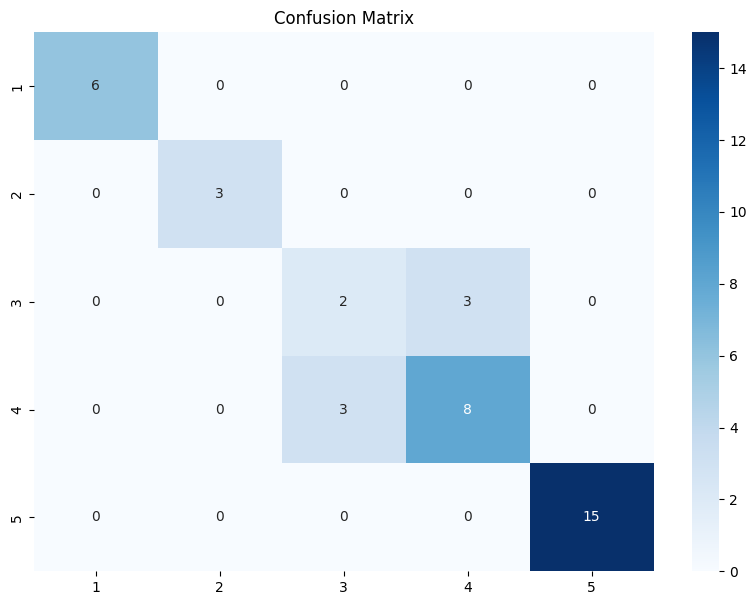

In [26]:
# Making predictions
predictions = cart_model.predict(X_test)

# Calculate and print the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy:.4f}")

# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[1, 2, 3, 4, 5], yticklabels=[1, 2, 3, 4, 5])
plt.title('Confusion Matrix')
plt.show()

Finally, we visualize the decision tree:

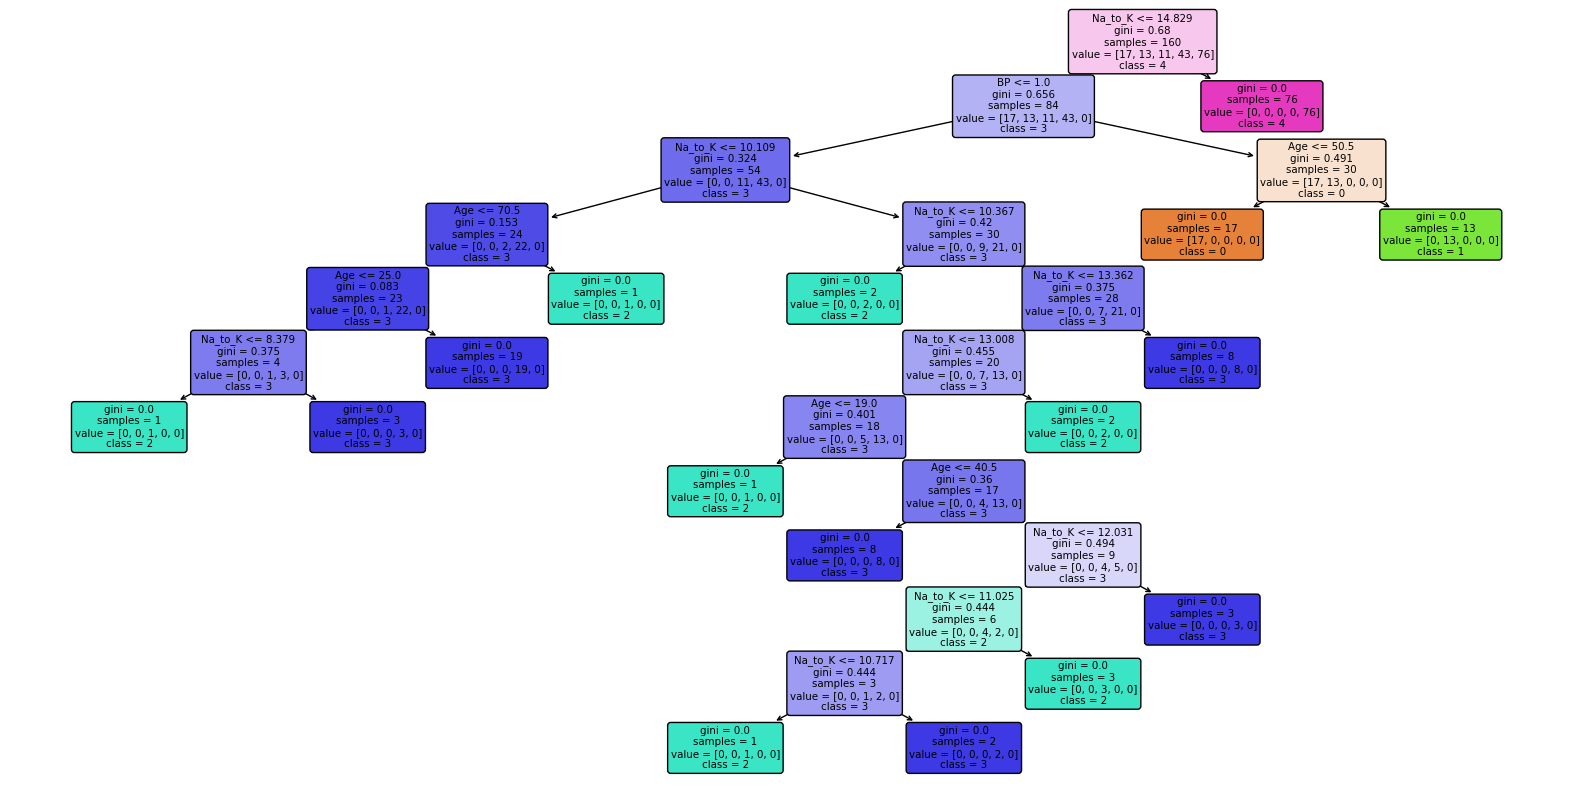

In [27]:
plt.figure(figsize=(20,10))
plot_tree(cart_model, 
          filled=True, 
          rounded=True, 
          class_names=['0', '1', '2', '3', '4'],  # Update class names as appropriate
          feature_names=list(X_train.columns))       # Ensure X_train.columns is accessible
plt.show()

#### Please interpret the results, try to answer the following:

- How well did both models predict heart disease presence?
- Describe the model's performance in terms of false positives, false negatives, true positives, and true negatives.
- Analyze the tree to determine the most important features and decision paths leading to heart disease prediction.

ID3
- Accuracy 80%

- Confusion matrix: only prediced 6 values wrongly in total, the majority predictions are true positives

- The most important variable that splits the data is BP, then Na_to_K, Age, sex, and cholesterol

CART
- Accuracy 85%

- Confusion matrix simmilar to ID3, majority of predictions are true positives

- The most important variable is Na_to_K, then BP, Age, it doesn't consider sex or cholesterol